In [8]:
import numpy as np

data=np.load('data.npy')  #get loaded images numpy array
labels=np.load('labels.npy') 


In [9]:
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [3]:
Sequential?

In [10]:
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications import MobileNetV2

In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))#taken pre-trained mobilenetV2 model
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
model = Model(inputs=baseModel.input, outputs=headModel) # place the head FC model on top of the base model (this will become the actual model we will train)
for layer in baseModel.layers:
    layer.trainable = False  # loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
aug = ImageDataGenerator(  # construct the training image generator for data augmentation
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 47s 1s/step - loss: 0.4131 - accuracy: 0.8174 - val_loss: 0.1046 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 50s 1s/step - loss: 0.1248 - accuracy: 0.9644 - val_loss: 0.0489 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 0.0685 - accuracy: 0.9813 - val_loss: 0.0330 - val_accuracy: 0.9964
Epoch 4/20
34/34 [==============================] - 49s 1s/step - loss: 0.0507 - accuracy: 0.9897 - val_loss: 0.0267 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 52s 2s/step - loss: 0.0402 - accuracy: 0.9878 - val_loss: 0.0212 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 49s 1s/step - loss: 0.0290 - accuracy: 0.9944 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 43s 1s/step - loss: 0.0260 - accuracy: 0.9972 - val_loss: 

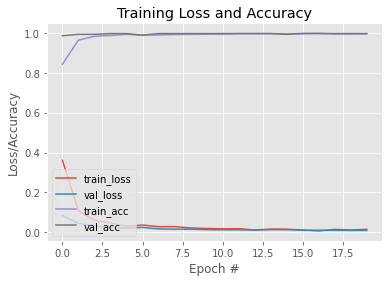

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [10]:
model.save('latest-model.h5')  #To save the trained model